In [ ]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D

from keras.preprocessing import image 
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/")  #put your location 

In [ ]:
driver_details = pd.read_csv('driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
## Getting all the images

driver_details = pd.read_csv('driver_imgs_list.csv',na_values='na')
train_image = []

for i in range(10):
    print('Current folder C',i)
    imgs = os.listdir("img/train/c"+str(i))
    for j in range(len(imgs)):
        img_name = "imgs2/train/c"+str(i)+"/" + imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])


Current folder C 0
Current folder C 1
Current folder C 2
Current folder C 3
Current folder C 4
Current folder C 5
Current folder C 6
Current folder C 7
Current folder C 8
Current folder C 9


In [ ]:
print(driver_details)


      subject classname            img
0        p002        c0  img_44733.jpg
1        p002        c0  img_72999.jpg
2        p002        c0  img_25094.jpg
3        p002        c0  img_69092.jpg
4        p002        c0  img_92629.jpg
...       ...       ...            ...
22419    p081        c9  img_56936.jpg
22420    p081        c9  img_46218.jpg
22421    p081        c9  img_25946.jpg
22422    p081        c9  img_67850.jpg
22423    p081        c9   img_9684.jpg

[22424 rows x 3 columns]


In [ ]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [ ]:
## Randomly shuffling the images
import random
random.shuffle(train_image)
## Splitting the train and test
driv_selected = ['p050', 'p015', 'p022', 'p056']
X_train= []
y_train = []
X_test = []
y_test = []
# D_train = []
# D_test = []

train_count_labels_wise = [0] * 10
test_count_labels_wise = [0] * 10
for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        test_count_labels_wise[labels]+=1

    else:
        X_train.append(features)
        y_train.append(labels)
        train_count_labels_wise[labels]+=1
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [ ]:
print(train_count_labels_wise)
print(test_count_labels_wise)

[2077, 1928, 1969, 1947, 1930, 1909, 1933, 1668, 1579, 1792]
[412, 339, 348, 399, 396, 403, 392, 334, 332, 337]


In [ ]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print (X_train.shape)


(18732, 224, 224, 3)


In [ ]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
import tensorflow as tf
from keras.layers import Input
from keras.applications.vgg16 import VGG16, preprocess_input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
from keras.models import Model
output_vgg16_conv = model_vgg16_conv(vgg16_input)
#Add the fully-connected layers 
x=GlobalAveragePooling2D()(output_vgg16_conv)
x=Dense(1024,activation='relu')(x) 
x = Dropout(0.1)(x) 
x=Dense(1024,activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) 
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pre = Model(inputs = vgg16_input, outputs = x)
vgg16_pre.summary()

# Compile CNN model
sgd =  tf.keras.optimizers.SGD(lr = 0.001)
vgg16_pre.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### Running VGG with Image Aumentation

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = os.path.join(os.getcwd()+"/model/","driver-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model = vgg16_pre.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size = 64, epochs = 10,callbacks=callbacks_list)

In [ ]:
train_loss = model.history['loss']
train_acc = model.history['accuracy']
val_loss = model.history['val_loss']
val_acc = model.history['val_accuracy']
xc=range(len(train_loss))


In [ ]:
print(train_loss)
print(train_acc)
print(val_loss)
print(val_acc)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

# **Load Your Model**


In [ ]:
from keras.models import load_model
BEST_MODEL = "model/driver-03-0.81.hdf5"
model = load_model(BEST_MODEL)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                           

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


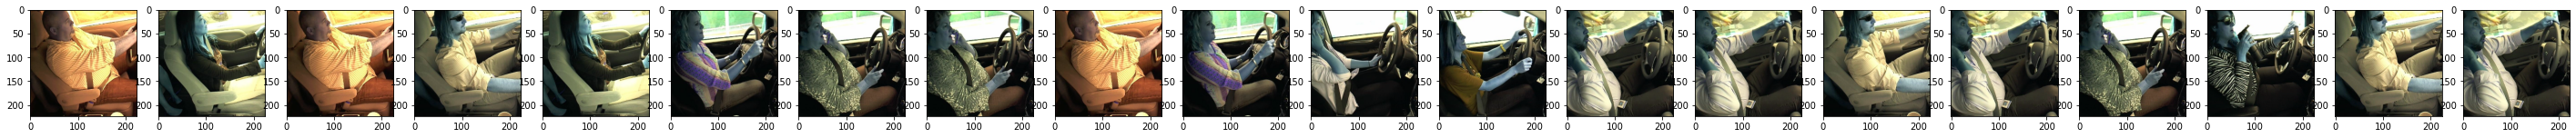

In [ ]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('imgs/yes')
nums = np.random.randint(low=1, high=len(files)-1, size=30)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('imgs/yes/'+files[nums[i]])
    if img is None:
      continue
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    # plt.show


In [ ]:
test = []
for img in test_image:
    test.append(img)
print(len(test))
test = np.array(test).reshape(-1,224,224,3)
test.shape

20


(20, 224, 224, 3)

In [ ]:
prediction = model.predict(test)

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

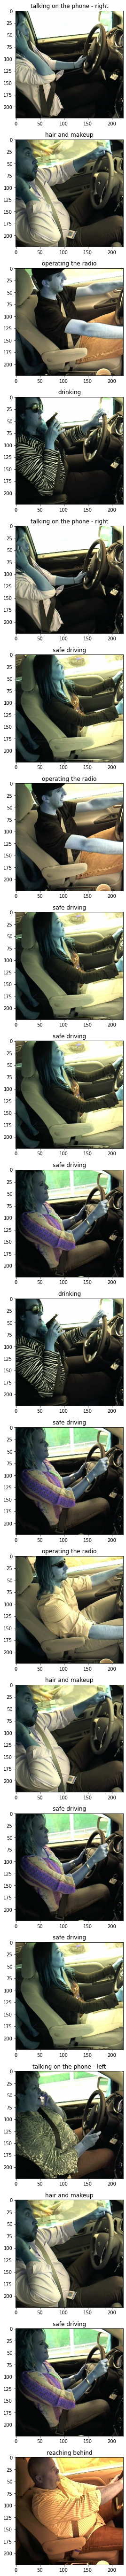

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))
for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show

In [ ]:
## Getting all the images
test_image = []
for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("imgs/my_test/c"+str(i))
    for j in range(len(imgs)):
        img_name = "imgs/my_test/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        test_image.append([img,label])


now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [ ]:
len(test_image)

4484

In [ ]:
## Randomly shuffling the images
import random
random.shuffle(test_image)
## Splitting the train and test
Xtest = []
ytest = []

for features,labels in test_image:
        Xtest.append(features)
        ytest.append(labels)

print (len(Xtest))
print (len(ytest))

4484
4484


In [ ]:
## Converting images to nparray. Encoding the Y

Xtest = np.array(Xtest).reshape(-1,224,224,3)
ytest = to_categorical(ytest)
print (Xtest.shape)

(4484, 224, 224, 3)


In [ ]:
test_loss, test_acc = model.evaluate(Xtest, ytest)
print(test_loss)
print(test_acc)

141/141 [==============================] - 57s 287ms/step - loss: 0.1523 - accuracy: 0.9632
0.15230196714401245
0.9632024765014648


In [ ]:
prediction = model.predict(Xtest)

In [ ]:
len(prediction)

4484

In [ ]:
ytest[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools
print('Confusion Matrix')
prediction_max = np.argmax(prediction, axis=1)
print(confusion_matrix(np.argmax(ytest,axis=1), prediction_max))

Confusion Matrix
[[484   1   7   1   0   0   0   0   3   3]
 [  3 449   0   0   0   0   1   0   0   0]
 [  0   0 461   0   0   0   2   0   0   0]
 [  3   0   0 464   2   0   0   0   0   0]
 [ 13   0   0   2 441   0   0   5   4   0]
 [  8   0   0   2   0 443   0   1   1   7]
 [  2   0   0   0   0   0 462   0   1   0]
 [  0   0   0   0   0   0   0 400   1   0]
 [  5   0   3   1   2   1   9  28 327   6]
 [  9   0   2   3   1  11   1   2   8 388]]


In [ ]:
import sklearn.metrics as metrics

In [ ]:
print(metrics.classification_report(np.argmax(ytest,axis=1), prediction_max, digits=3))

              precision    recall  f1-score   support

           0      0.918     0.970     0.943       499
           1      0.998     0.991     0.994       453
           2      0.975     0.996     0.985       463
           3      0.981     0.989     0.985       469
           4      0.989     0.948     0.968       465
           5      0.974     0.959     0.966       462
           6      0.973     0.994     0.983       465
           7      0.917     0.998     0.956       401
           8      0.948     0.856     0.900       382
           9      0.960     0.913     0.936       425

    accuracy                          0.963      4484
   macro avg      0.963     0.961     0.962      4484
weighted avg      0.964     0.963     0.963      4484

